In [82]:
import kaolin
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import polyscope as ps
import interactive_polyscope
from scipy.spatial import Voronoi, voronoi_plot_2d
from io import BytesIO
from PIL import Image
import sdfpred_utils.sdfpred_utils as su
import sdfpred_utils.sdf_MLP as mlp
import sdfpred_utils.sdf_functions as sdf
import sdfpred_utils.loss_functions as lf
import trimesh
from scipy.spatial import Delaunay, Voronoi


#cuda devices
device = torch.device("cuda:0")
print("Using device: ", torch.cuda.get_device_name(device))

#default tensor types
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

multires = 2
input_dims = 3
lr_sites = 0.03
lr_model = 0.0003
iterations = 5000
save_every = 100
max_iter = 100
#learning_rate = 0.03
destination = "./images/autograd/3D/"


Using device:  NVIDIA GeForce RTX 3050 Laptop GPU


In [83]:
#currently sites are between -5 and 5 in all 3 dimensions
# check if sites exists
#num_centroids = 16*16*16
num_centroids = 8*8*8
site_fp = f'sites_{num_centroids}.pt'

if os.path.exists(site_fp):
    sites = torch.load(site_fp)
else:
    sites = su.createCVTgrid(num_centroids=num_centroids, dimensionality=input_dims)
    #save the initial sites torch tensor
    torch.save(sites, site_fp)


def plot_voronoi_3d(sites, xlim=5, ylim=5, zlim=5):
    import numpy as np
    import pyvoro
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    # initialize random number generator
    rng = np.random.default_rng(11)
    # create a set of points in 3D
    points = sites.detach().cpu().numpy()

    # use pyvoro to compute the Voronoi tessellation
    # the second argument gives the the axis limits in x,y and z direction
    # in this case all between 0 and 1.
    # the third argument gives "dispersion = max distance between two points
    # that might be adjacent" (not sure how exactly this works)
    voronoi = pyvoro.compute_voronoi(points,[[-xlim,xlim],[-ylim,ylim],[-zlim,zlim]],1)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # for each Voronoi cell, plot all the faces of the corresponding polygon
    for vnoicell in voronoi:
        faces = []
        # the vertices are the corner points of the Voronoi cell
        vertices = np.array(vnoicell['vertices'])
        # cycle through all faces of the polygon
        for face in vnoicell['faces']:
            faces.append(vertices[np.array(face['vertices'])])
            
        # join the faces into a 3D polygon
        polygon = Poly3DCollection(faces, alpha=0.5, 
                                facecolors=rng.uniform(0,1,3),
                                linewidths=0.5,edgecolors='black')
        ax.add_collection3d(polygon)
    
    ax.set_xlim([-xlim,xlim])
    ax.set_ylim([-ylim,ylim])
    ax.set_zlim([-zlim,zlim])
            
    plt.show()

#plot_voronoi_3d(sites)

In [84]:
ps.init()
#ps_cloud = ps.register_point_cloud("initial_cvt_grid",sites.detach().cpu().numpy())

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 3.3.0 NVIDIA 570.86.16


In [85]:

# Load the mesh
mesh = ["bunny", "Resources/stanford-bunny.obj"]
bunny = trimesh.load(mesh[1])

# Step 1: Get current bounding box
min_bound = bunny.bounds[0]  # Min (x, y, z)
max_bound = bunny.bounds[1]  # Max (x, y, z)

# Step 2: Compute scale factor
current_size = max_bound - min_bound  # Size in each dimension
target_size = 8  # Because we want [-5, 5], the total size is 10

scale_factor = target_size / np.max(current_size)  # Scale based on the largest dimension

# Step 3: Compute new center after scaling
new_vertices = bunny.vertices * scale_factor  # Scale the vertices
new_min = np.min(new_vertices, axis=0)
new_max = np.max(new_vertices, axis=0)
new_center = (new_min + new_max) / 2  # New center after scaling

# Step 4: Compute translation to center the bunny at (0,0,0)
translation = -new_center  # Move to the origin

# Step 5: Apply transformation (scaling + translation)
bunny.vertices = new_vertices + translation

target_points = bunny.sample(16*16*16)
target_points = torch.tensor(target_points, device=device)

#ps_cloud = ps.register_point_cloud("Target_points",target_points.detach().cpu().numpy())


In [86]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=input_dims).to(device)
model_path = 'models_resources/pretrained_sphere_small.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_sphere(3000)
    torch.save(model.state_dict(),model_path)
    
def polyscope_sdf(model):
    # Render the SDF as an implicit surface (zero-level set)
    def model_sdf(pts):
        pts_tensor = torch.tensor(pts, dtype=torch.float64, device=device)
        sdf_values = model(pts_tensor)
        sdf_values_np = sdf_values.detach().cpu().numpy().flatten()  # Convert to NumPy
        
        return sdf_values_np

    ps.render_implicit_surface("SDF Surface", model_sdf, mode="sphere_march", enabled=True)



loaded model


In [ ]:
#Todo this should also work in 2d, might want to adjust the simplex iteration
def get_delaunay_neighbors_list_3d_and_all_voronoi_vertices_index(sites):
    # Detach and convert to NumPy for Delaunay triangulation
    points_np = sites.detach().cpu().numpy()
    
    # Compute the Delaunay tessellation
    tri = Delaunay(points_np)
    vor = Voronoi(points_np)
    
    # # # Find the neighbors of each point
    # neighbors = {i: set() for i in range(len(points_np))}
    # for simplex in tri.simplices:  # Each simplex is a tetrahedron (4 points)
    #     for i in range(4):  # Iterate over each of the 4 vertices
    #         for j in range(i + 1, 4):  # Connect each pair of points
    #             neighbors[simplex[i]].add(simplex[j])
    #             neighbors[simplex[j]].add(simplex[i])

    # # Convert sets to lists for easier use
    # neighbors = {key: list(value) for key, value in neighbors.items()}
    
    n2 = vor.ridge_points    
    voronoi_vertices_sites = tri.simplices
    
    #todo remove neighbors
    
    #return neighbors, n2, voronoi_vertices_sites
    return n2, voronoi_vertices_sites


#todo deprecate because im dumb
# def compute_vertices_index_3d(neighbors):
#     vertices_index_to_compute = []
#     for site, adjacents in neighbors.items():
#         for i in adjacents:
#             for n in adjacents:
#                 if n != site and n != i and n in neighbors[i]:  # Ensuring a triangle exists
#                     for m in adjacents:
#                         if m != site and m != i and m != n and m in neighbors[i] and m in neighbors[n]:
#                             # We now have 4 mutually connected points forming a tetrahedron
#                             vertices_index_to_compute.append([i, site, n, m])
    
#     # Deduplicate tetrahedra (avoid different orderings of the same set)
#     seen_tetrahedra = set()
#     filtered_tetrahedra = []

#     for tetrahedron in vertices_index_to_compute:
#         canonical_tetrahedron = tuple(sorted(tetrahedron, key=str))  # Sort for uniqueness
#         if canonical_tetrahedron not in seen_tetrahedra:
#             seen_tetrahedra.add(canonical_tetrahedron)
#             filtered_tetrahedra.append(tetrahedron)
    
#     return filtered_tetrahedra


def compute_zero_crossing_vertices_3d(sites, model):
    """
    Computes the indices of the sites composing vertices where neighboring sites have opposite or zero SDF values.

    Args:
        sites (torch.Tensor): (N, D) tensor of site positions.
        model (callable): Function or neural network that computes SDF values.

    Returns:
        zero_crossing_vertices_index (list of triplets): List of sites indices (si, sj, sk) where atleast 2 sites have opposing SDF signs.
    """
    # Compute Delaunay neighbors
    #neighbors, n2, all_tetrahedra = get_delaunay_neighbors_list_3d_and_all_voronoi_vertices_index(sites)
    n2, all_tetrahedra = get_delaunay_neighbors_list_3d_and_all_voronoi_vertices_index(sites)

    # Compute SDF values for all sites
    sdf_values = model(sites)  # Assuming model outputs (N, 1) or (N,) tensor


    # #todo, probably using voronoi.ridgeopints is faster
    # # Find pairs of neighbors with opposing SDF values
    # zero_crossing_pairs = set()
    # for i, adjacents in neighbors.items():
    #     for j in adjacents:
    #         if i < j:  # Avoid duplicates
    #             sdf_i, sdf_j = sdf_values[i].item(), sdf_values[j].item()
    #             if sdf_i * sdf_j <= 0:  # Opposing signs or one is zero
    #                 zero_crossing_pairs.add((i, j))
   
    # zero_crossing_vertices_index = []
    
    # for tetrahedron in all_tetrahedra:
    #     tetrahedron_pairs = {
    #         (tetrahedron[0], tetrahedron[1]), (tetrahedron[0], tetrahedron[2]), (tetrahedron[0], tetrahedron[3]),
    #         (tetrahedron[1], tetrahedron[2]), (tetrahedron[1], tetrahedron[3]), (tetrahedron[2], tetrahedron[3])
    #     }
    #     if any(pair in zero_crossing_pairs for pair in tetrahedron_pairs):
    #         zero_crossing_vertices_index.append(tetrahedron)


    # print("zero_crossing_vertices_index_LIST", len(zero_crossing_vertices_index))
    # print("zero_crossing_pairs_bisectors_LIST", len(zero_crossing_pairs))
    # zero_crossing_pairs = list(zero_crossing_pairs)
    # zero_crossing_pairs = torch.tensor(np.array(zero_crossing_pairs), device=device)
    


    #todo fix this as its the good way to do it
    neighbors = torch.tensor(np.array(n2), device=device)
    all_tetrahedra = torch.tensor(np.array(all_tetrahedra), device=device)
    
    # Extract the SDF values for each site in the pair
    sdf_i = sdf_values[neighbors[:, 0]]  # First site in each pair
    sdf_j = sdf_values[neighbors[:, 1]]  # Second site in each pair
    # Find the indices where SDF values have opposing signs or one is zero
    mask_zero_crossing_sites = (sdf_i * sdf_j <= 0).squeeze()
    zero_crossing_pairs = neighbors[mask_zero_crossing_sites]

    sdf_0 = sdf_values[all_tetrahedra[:, 0]]  # First site in each pair
    sdf_1 = sdf_values[all_tetrahedra[:, 1]]  # Second site in each pair
    sdf_2 = sdf_values[all_tetrahedra[:, 2]]  # Third site in each pair
    sdf_3 = sdf_values[all_tetrahedra[:, 3]]  # Fourth site in each pair
    mask_zero_crossing_faces = (sdf_0*sdf_1<=0).squeeze() | (sdf_0*sdf_2<=0).squeeze() | (sdf_0*sdf_3<=0).squeeze() | (sdf_1*sdf_2<=0).squeeze() | (sdf_1*sdf_3<=0).squeeze() | (sdf_2*sdf_3<=0).squeeze()
    zero_crossing_vertices_index = all_tetrahedra[mask_zero_crossing_faces]
    return zero_crossing_vertices_index, zero_crossing_pairs

# def compute_vertex_3d(s_i, s_j, s_k, s_l):
#     """
#     Computes the circumcenter of a tetrahedron given four sites in 3D.

#     Args:
#         s_i, s_j, s_k, s_l (torch.Tensor): 3D coordinates of four sites (shape: (3,)).

#     Returns:
#         torch.Tensor: The circumcenter (x, y, z).
#     """
#     # Convert to coordinate form
#     x_i, y_i, z_i = s_i
#     x_j, y_j, z_j = s_j
#     x_k, y_k, z_k = s_k
#     x_l, y_l, z_l = s_l

#     # Compute squared norms
#     s_i2 = x_i**2 + y_i**2 + z_i**2
#     s_j2 = x_j**2 + y_j**2 + z_j**2
#     s_k2 = x_k**2 + y_k**2 + z_k**2
#     s_l2 = x_l**2 + y_l**2 + z_l**2

#     # Construct matrix system
#     A = torch.tensor([
#         [x_i, y_i, z_i, 1],
#         [x_j, y_j, z_j, 1],
#         [x_k, y_k, z_k, 1],
#         [x_l, y_l, z_l, 1]
#     ], dtype=torch.float32)

#     Dx = torch.tensor([
#         [s_i2, y_i, z_i, 1],
#         [s_j2, y_j, z_j, 1],
#         [s_k2, y_k, z_k, 1],
#         [s_l2, y_l, z_l, 1]
#     ], dtype=torch.float32)

#     Dy = torch.tensor([
#         [x_i, s_i2, z_i, 1],
#         [x_j, s_j2, z_j, 1],
#         [x_k, s_k2, z_k, 1],
#         [x_l, s_l2, z_l, 1]
#     ], dtype=torch.float32)

#     Dz = torch.tensor([
#         [x_i, y_i, s_i2, 1],
#         [x_j, y_j, s_j2, 1],
#         [x_k, y_k, s_k2, 1],
#         [x_l, y_l, s_l2, 1]
#     ], dtype=torch.float32)

#     # Compute determinants
#     detA = torch.det(A)
#     detDx = torch.det(Dx)
#     detDy = torch.det(Dy)  # todo, removed Negative due to orientation
#     detDz = torch.det(Dz)

#     # Compute circumcenter coordinates
#     x = 0.5 * (detDx / detA)
#     y = 0.5 * (detDy / detA)
#     z = 0.5 * (detDz / detA)

#     #todo -y is weird but always gives the right answer when comparing with vor.vertices
#     #maybe error in matrix computation
#     return torch.stack([x, y, z])

# def compute_all_vertices_3d(sites, vertices_to_compute):
#     """
#     Computes all Voronoi vertices for a given set of tetrahedra.

#     Args:
#         sites (torch.Tensor): (N, 3) tensor of site positions.
#         vertices_to_compute (list of quadruplets): List of indices forming tetrahedra.

#     Returns:
#         torch.Tensor: Computed Voronoi vertices.
#     """
#     vertices = []
    
#     for quadruplet in vertices_to_compute:
#         si = sites[quadruplet[0]]
#         sj = sites[quadruplet[1]]
#         sk = sites[quadruplet[2]]
#         sl = sites[quadruplet[3]]

#         # Compute circumcenter for the tetrahedron
#         v = compute_vertex_3d(si, sj, sk, sl)
#         vertices.append(v)

#     # Stack all vertices into a single tensor
#     vertices = torch.stack(vertices)
#     return vertices

def compute_vertices_3d_vectorized(sites, vertices_to_compute):
    """
    Computes the circumcenters of multiple tetrahedra in a vectorized manner.

    Args:
        sites (torch.Tensor): (N, 3) tensor of site positions.
        vertices_to_compute (torch.Tensor): (M, 4) tensor of indices forming tetrahedra.

    Returns:
        torch.Tensor: (M, 3) tensor of computed Voronoi vertices.
    """
    # Extract tetrahedra site coordinates in a batched manner
    tetrahedra = sites[vertices_to_compute]  # Shape: (M, 4, 3)

    # Compute squared norms of each point
    squared_norms = (tetrahedra ** 2).sum(dim=2, keepdim=True)  # Shape: (M, 4, 1)

    # Construct the 4x4 matrices in batch
    ones_col = torch.ones_like(squared_norms)  # Column of ones for homogeneous coordinates

    A = torch.cat([tetrahedra, ones_col], dim=2)  # Shape: (M, 4, 4)
    Dx = torch.cat([squared_norms, tetrahedra[:, :, 1:], ones_col], dim=2)
    Dy = torch.cat([tetrahedra[:, :, :1], squared_norms, tetrahedra[:, :, 2:], ones_col], dim=2)
    Dz = torch.cat([tetrahedra[:, :, :2], squared_norms, ones_col], dim=2)

    # Compute determinants in batch
    detA = torch.linalg.det(A)  # Shape: (M,)
    detDx = torch.linalg.det(Dx)
    detDy = torch.linalg.det(Dy)  # todo, removed Negative due to orientation
    detDz = torch.linalg.det(Dz)

    # Compute circumcenters
    circumcenters = 0.5 * torch.stack([detDx / detA, detDy / detA, detDz / detA], dim=1)

    return circumcenters  # Shape: (M, 3)




# #Todo its the same in 3d if we only want a point. Do we want the plane ?
# def compute_all_bisectors_3d(sites, bisectors_to_compute):
#     # Initialize an empty tensor for storing bisectors
#     bisectors = []
    
#     for pairs in bisectors_to_compute:
#         si = sites[pairs[0]]
#         sj = sites[pairs[1]]
#         b = (si + sj) / 2
#         bisectors.append(b)

#     # Stack the list of bisectors into a single tensor for easier gradient tracking
#     bisectors = torch.stack(bisectors)
#     return bisectors


def compute_all_bisectors_3d_vectorized(sites, bisectors_to_compute):
    """
    Computes the bisector points for given pairs of sites in 3D.

    Args:
        sites (torch.Tensor): (N, 3) tensor of site positions.
        bisectors_to_compute (torch.Tensor): (M, 2) tensor of index pairs.

    Returns:
        torch.Tensor: (M, 3) tensor of computed bisector points.
    """
    # Extract all site pairs at once
    si = sites[bisectors_to_compute[:, 0]]  # Shape: (M, 3)
    sj = sites[bisectors_to_compute[:, 1]]  # Shape: (M, 3)

    # Compute bisectors in a single vectorized operation
    bisectors = (si + sj) / 2  # Shape: (M, 3)

    return bisectors


#Todo see above
# def compute_all_bisector_planes_3d(sites, bisectors_to_compute):
#     """
#     Computes bisector planes for given site pairs in 3D.

#     Args:
#         sites (torch.Tensor): (N, 3) tensor of site positions.
#         bisectors_to_compute (list of pairs): List of index pairs (i, j).

#     Returns:
#         torch.Tensor: Plane normals (N, 3) and midpoints (N, 3).
#     """
#     midpoints = []
#     normals = []
    
#     for pair in bisectors_to_compute:
#         si = sites[pair[0]]
#         sj = sites[pair[1]]
        
#         midpoint = (si + sj) / 2  # Midpoint
#         normal = sj - si  # Normal direction
        
#         midpoints.append(midpoint)
#         normals.append(normal)

#     # Stack into tensors
#     midpoints = torch.stack(midpoints)
#     normals = torch.stack(normals)
    
#     return normals, midpoints





In [88]:

cvt_loss_values = []
min_distance_loss_values = []
edge_smoothing_loss_values = []
chamfer_distance_loss_values = []
eikonal_loss_values = []
domain_restriction_loss_values = []
zero_target_points_loss_values = []
loss_values = []

def autograd(sites, model, max_iter=100, stop_train_threshold=1e-6, upsampling=0, lambda_weights = [0.1,1.0,0.1,0.1,1.0,1.0,0.1]):
    optimizer = torch.optim.Adam([
    {'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
    {'params': [sites], 'lr': lr_sites}
], betas=(0.5, 0.999))

    prev_loss = float("inf")
    best_loss = float("inf")
    upsampled = 0.0
    epoch = 0
    lambda_cvt = lambda_weights[0]
    lambda_sdf = lambda_weights[1]
    lambda_min_distance = lambda_weights[2]
    lambda_laplace = lambda_weights[3]
    lamda_chamfer = lambda_weights[4]
    lamda_eikonal = lambda_weights[5]
    lambda_domain_restriction = lambda_weights[6]
    lambda_target_points = lambda_weights[7]
    
    best_sites = sites.clone()
    best_sites.best_loss = best_loss
    
    while epoch <= max_iter:
        optimizer.zero_grad()
        
        vertices_to_compute, bisectors_to_compute = compute_zero_crossing_vertices_3d(sites, model)
        #vertices_to_compute to array before tensor because extremely slow
        
        #vertices = compute_all_vertices_3d(sites, vertices_to_compute)
        vertices = compute_vertices_3d_vectorized(sites, vertices_to_compute)
        print("vertices length: ",len(vertices))
        
        bisectors = compute_all_bisectors_3d_vectorized(sites, bisectors_to_compute)

        
        #combine vertices and bisectors to one tensor for chamfer
        points = torch.cat((vertices, bisectors), 0)

        print("points length: ",len(points))
  

        # Compute losses       
        cvt_loss = lf.compute_cvt_loss(sites)
        #min_distance_loss = min_distance_regularization_for_op_sites(edges,sites)
        #min_distance_loss = lf.sdf_weighted_min_distance_loss(model, sites)
        #edge_smoothing_loss = compute_edge_smoothing_loss(edges, sites, model)
        chamfer_loss = lf.chamfer_distance(target_points, points)
        eikonal_loss = lf.eikonal(model, input_dimensions=input_dims)
        #domain_restriction_loss = lf.domain_restriction(target_points, model)
        
        sdf_values_target_points = model(target_points)[:,0]
        zero_target_points_loss_L2 = torch.mean(sdf_values_target_points**2)
        zero_target_points_loss_L1 = torch.mean(torch.abs(model(target_points)[:, 0]))
        lambda_1, lambda_2 = 0 , 0.99  # Adjust weights as needed
        zero_target_points_loss = lambda_1 * zero_target_points_loss_L1 + lambda_2 * zero_target_points_loss_L2

               
        # Track raw losses (unweighted)
        #cvt_loss_values.append(cvt_loss.item())
        #min_distance_loss_values.append(min_distance_loss.item())
        #edge_smoothing_loss_values.append(edge_smoothing_loss.item())
        chamfer_distance_loss_values.append(chamfer_loss.item())
        eikonal_loss_values.append(eikonal_loss.item())
        #domain_restriction_loss_values.append(domain_restriction_loss.item())
        zero_target_points_loss_values.append(zero_target_points_loss.item())
  
        loss = (
            lambda_cvt * cvt_loss +
            #lambda_min_distance * min_distance_loss + 
            #lambda_laplace * edge_smoothing_loss +
            lamda_chamfer * chamfer_loss +
            lamda_eikonal * eikonal_loss +
            #lambda_domain_restriction * domain_restriction_loss +
            lambda_target_points * zero_target_points_loss
        )
        loss_values.append(loss.item())
        print(f"Epoch {epoch}: loss = {loss.item()}")
                
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            if upsampled > 0:
                print(f"UPSAMPLED {upsampled} Best Epoch {best_epoch}: Best loss = {best_loss}")
                #return best_sites
        
        if abs(prev_loss - loss.item()) < stop_train_threshold:
            print(f"Converged at epoch {epoch} with loss {loss.item()}")
            #break
        
        prev_loss = loss.item() 
        
        if epoch>100 and (epoch // 100) == upsampled+1 and loss.item() < 0.5 and upsampled < upsampling:
            print("sites length: ",len(sites))
            
            new_sites = su.upsampling_inside(best_sites, model)
            #new_sites = su.adaptive_density_upsampling(best_sites, model)
            print(new_sites)
            sites = su.add_upsampled_sites(best_sites, new_sites)
            sites = sites.detach().requires_grad_(True)
            print("upsampled sites length: ",len(sites))
            
            best_sites = sites.clone()
            best_sites.best_loss = best_loss
            
            optimizer = torch.optim.Adam([{'params': [p for _, p in model.named_parameters()], 'lr': lr_model},
                                          {'params': [sites], 'lr': lr_sites}])
            upsampled += 1.0
          
        if epoch % (max_iter/10) == 0:
            print(f"Epoch {epoch}: loss = {loss.item()}")
            print(f"Best Epoch {best_epoch}: Best loss = {best_loss}")
            #save model and sites
            site_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_sites_{num_centroids}_chamfer{lamda_chamfer}.pth'
            model_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_model_{num_centroids}_chamfer{lamda_chamfer}.pth'
            torch.save(model.state_dict(), model_file_path)
            torch.save(sites, site_file_path)
            
        
        epoch += 1           
        
    return best_sites

vertices length:  213
points length:  350
Epoch 0: loss = 43.36182276838465
Epoch 0: loss = 43.36182276838465
Best Epoch 0: Best loss = 43.36182276838465
vertices length:  328
points length:  542
Epoch 1: loss = 42.526124078247726
vertices length:  444
points length:  734
Epoch 2: loss = 365.06956758748584
vertices length:  585
points length:  967
Epoch 3: loss = 153.89211282136688
vertices length:  770
points length:  1270
Epoch 4: loss = 34.46955226573633
vertices length:  896
points length:  1476
Epoch 5: loss = 230.3493893595988
vertices length:  852
points length:  1408
Epoch 6: loss = 20.957820204836796
vertices length:  812
points length:  1341
Epoch 7: loss = 234.64749073079557
vertices length:  702
points length:  1161
Epoch 8: loss = 3442.523465238782
vertices length:  663
points length:  1096
Epoch 9: loss = 72.02292630426085
vertices length:  680
points length:  1122
Epoch 10: loss = 27.905555227312792
Epoch 10: loss = 27.905555227312792
Best Epoch 6: Best loss = 20.9578202

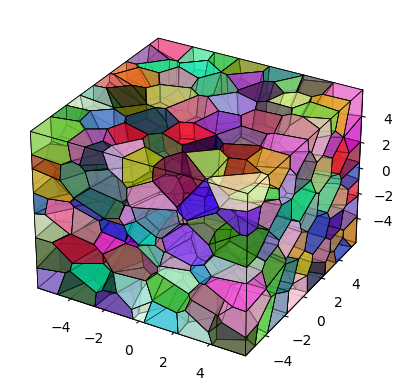

In [89]:

lambda_weights = [0.2,0,0.1,0,1.0001101101000101,0.1,0,2]

lambda_cvt = lambda_weights[0]
lambda_sdf = lambda_weights[1]
lambda_min_distance = lambda_weights[2]
lambda_laplace = lambda_weights[3]
lamda_chamfer = lambda_weights[4]
lambda_eikonal = lambda_weights[5]
lambda_domain_restriction = lambda_weights[6]
lambda_target_points = lambda_weights[7]

max_iter = 100

site_file_path = f'{destination}{mesh[0]}{max_iter}3d_sites_{num_centroids}_chamfer{lamda_chamfer}.npy'
#check if optimized sites file exists
if os.path.exists(site_file_path):
    #import sites
    print("Importing sites")
    sites = np.load(site_file_path)
    sites = torch.from_numpy(sites).to(device).requires_grad_(True)    
else:
    import cProfile, pstats
    import time
    profiler = cProfile.Profile()
    profiler.enable()
    sites = autograd(sites, model, max_iter=max_iter, upsampling=0, lambda_weights=lambda_weights)
    
    profiler.disable()
    stats = pstats.Stats(profiler).sort_stats('cumtime')
    stats.print_stats()
    stats.dump_stats(f'{destination}{mesh[0]}{max_iter}_3d_profile_{num_centroids}_chamfer{lamda_chamfer}.prof')
    
    
    sites_np = sites.detach().cpu().numpy()
    np.save(site_file_path, sites_np)
    

print("Sites length: ", len(sites))
print("min sites: ", torch.min(sites))
print("max sites: ", torch.max(sites))
ps_cloud = ps.register_point_cloud("best_optimized_cvt_grid",sites.detach().cpu().numpy())
    
lim=torch.abs(torch.max(sites)).detach().cpu().numpy()*1.1
plot_voronoi_3d(sites,lim,lim,lim)

In [90]:
assert False

AssertionError: 

In [ ]:
epoch = 100

model_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_model_{num_centroids}_chamfer{lamda_chamfer}.pth'
site_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_sites_{num_centroids}_chamfer{lamda_chamfer}.pth'
sites = torch.load(site_file_path)
sites_np = sites.detach().cpu().numpy()
model.load_state_dict(torch.load(model_file_path))
#
#polyscope_sdf(model)
#
print("model", model_file_path)
print("sites", site_file_path)
#ps_cloud = ps.register_point_cloud(f"{epoch} epoch_cvt_grid",sites_np)



NameError: name 'mesh' is not defined

In [ ]:
def get_zero_crossing_mesh_3d(sites, model):
    sites_np = sites.detach().cpu().numpy()
    vor = Voronoi(sites_np)  # Compute 3D Voronoi diagram

    sdf_values = model(sites)[:, 0].detach().cpu().numpy()  # Compute SDF values

    valid_faces = []  # List of polygonal faces
    used_vertices = set()  # Set of indices for valid vertices

    for (point1, point2), ridge_vertices in zip(vor.ridge_points, vor.ridge_vertices):
        if -1 in ridge_vertices:
            continue  # Skip infinite ridges

        # Check if SDF changes sign across this ridge
        if np.sign(sdf_values[point1]) != np.sign(sdf_values[point2]):
            valid_faces.append(ridge_vertices)
            used_vertices.update(ridge_vertices)

    # **Filter Voronoi vertices**
    used_vertices = sorted(used_vertices)  # Keep unique, sorted indices
    vertex_map = {old_idx: new_idx for new_idx, old_idx in enumerate(used_vertices)}
    filtered_vertices = vor.vertices[used_vertices]

    # **Re-index faces to match the new filtered vertex list**
    filtered_faces = [[vertex_map[v] for v in face] for face in valid_faces]

    return filtered_vertices, filtered_faces



final_mesh = get_zero_crossing_mesh_3d(sites, model)

ps.register_surface_mesh("Zero-Crossing faces", final_mesh[0], final_mesh[1])
ps.register_point_cloud("Mesh vertices", final_mesh[0])

ps.show()



In [ ]:
def export_visualisation_3d():
    import imageio
    img_buffer_mesh = []
    img_buffer_model = []
    for i in range(int(max_iter/10)+1):
        epoch = i*10
        site_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_sites_{num_centroids}_chamfer{lamda_chamfer}.pth'
        model_file_path = f'{destination}{mesh[0]}{max_iter}_{epoch}_3d_model_{num_centroids}_chamfer{lamda_chamfer}.pth'
        
        print("mesh of epoch: ", epoch)
        
        model.load_state_dict(torch.load(model_file_path))
    
        current_mesh = get_zero_crossing_mesh_3d(torch.load(site_file_path), model)
        ps.remove_all_structures()
        ps.register_surface_mesh("Zero-Crossing faces", current_mesh[0], current_mesh[1])
        ps.register_point_cloud("Mesh vertices", current_mesh[0])
        img_buffer_mesh.append(ps.screenshot_to_buffer(transparent_bg=False))
        
        ps.remove_all_structures()
        polyscope_sdf(model)
        img_buffer_model.append(ps.screenshot_to_buffer(transparent_bg=False))


    imageio.mimsave(f'{destination}{max_iter}_3d_optimization_mesh.gif',img_buffer_mesh, fps=1, duration=1, loop=0)
    imageio.mimsave(f'{destination}{max_iter}_3d_optimization_sdf.gif', img_buffer_model, fps=1, duration=1, loop=0)

export_visualisation_3d()

loaded model


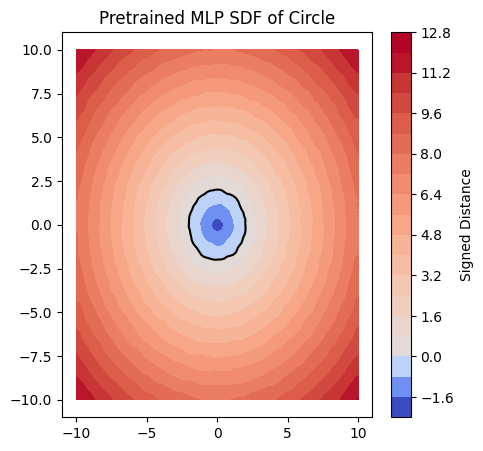

In [ ]:
import matplotlib
import os

model = mlp.Decoder(multires=multires, input_dims=2).to(device)
model_path = 'models_resources/pretrained_circle.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print('loaded model')
else:
    print("no model found, pretraining")
    model.pre_train_circle(3000, radius=1.0)
    torch.save(model.state_dict(),model_path)

#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")
plt.title("Pretrained MLP SDF of Circle")
plt.xlim(-11, 11)
plt.ylim(-11, 11)

plt.show()

torch.Size([5120, 2]) torch.float64
Delaunay simplices:  [[4400 2336  965]
 [2864 2351 1160]
 [ 170 2864 1160]
 ...
 [1562  909 4820]
 [1562 2584 1631]
 [ 909 1562 1631]]


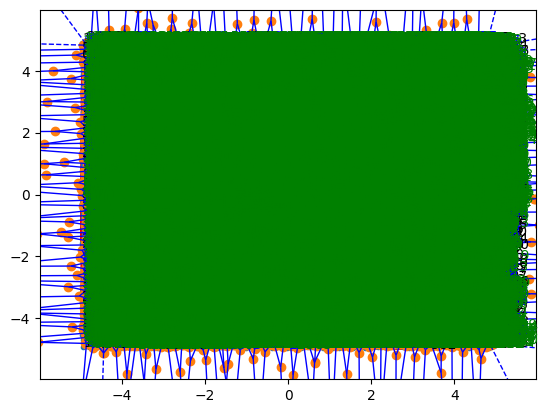

In [ ]:

import numpy as np
from scipy.spatial import Delaunay, Voronoi
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import sdfpred_utils.sdfpred_utils as su



points = np.array([[-1.29121883, 0.04024019],
 [ 3.82579886,  0.01307893],
 [-0.0435634,  -3.37884161],
 [-3.34000104,  3.34717147],
 [-3.80725371, -0.0696819 ],
 [ 0.01656605,  3.39162777],
 [ 1.31297362,  0.0107052 ],
 [ 3.32053027, -3.36299312],
 [ 3.33716388,  3.39748507],
 [-3.35475875, -3.38574726]])

points = np.array(su.createCVTgrid(num_centroids=5120).detach().cpu())

voronoi_initial = Voronoi(points[:,:2])

# Compute Delaunay triangulation
delaunay_triangulation = Delaunay(points[:,:2])

#print("Voronoi ridges: ", voronoi_initial.ridge_points)
#print("Voronoi vertices: ", voronoi_initial.vertices)
print("Delaunay simplices: ", delaunay_triangulation.simplices)


fig, ax = plt.subplots()
voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=True, line_colors='blue')
#plot points index
for i, point in enumerate(points):
    ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')

#plot the delaunay simplices with index
for i, simplex in enumerate(delaunay_triangulation.simplices):
    # Compute the circumcenter of the simplex
    circumcenter = np.mean(points[simplex], axis=0)
    ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

# plot the ridge points with index
for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    # Compute the midpoint of the ridge
    midpoint = (points[point1] + points[point2]) / 2
    ax.text(midpoint[0], midpoint[1], str(i), color='green')

# # Plot the points
# plt.scatter(points[:, 0], points[:, 1], color='blue')
# #change color of point 0
# plt.scatter(points[0, 0], points[0, 1], color='red')
# Plot the Delaunay triangulation
ax.triplot(points[:, 0], points[:, 1], delaunay_triangulation.simplices, color='red')
# plt.xlim(-6, 6)
# plt.ylim(-6, 6)
plt.show()

In [ ]:
ridges = voronoi_initial.ridge_points
vertices = voronoi_initial.vertices
simplices = delaunay_triangulation.simplices

sdf_values = model(torch.tensor(points, device=device))  # Assuming model outputs (N, 1) or (N,) tensor

#todo fix this as its the good way to do it
neighbors = torch.tensor(np.array(ridges), device=device)
all_tetrahedra = torch.tensor(np.array(simplices), device=device)

# Extract the SDF values for each site in the pair
sdf_i = sdf_values[neighbors[:, 0]]  # First site in each pair
sdf_j = sdf_values[neighbors[:, 1]]  # Second site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask = (sdf_i * sdf_j <= 0).squeeze()
zero_crossing_pairs = neighbors[mask]

print("zero_crossing_pairs_TORCH", zero_crossing_pairs)


zero_crossing_pairs_TORCH tensor([[2453, 3909],
        [2453, 1063],
        [3088,  899],
        [3088, 4015],
        [3909, 1462],
        [3909,  666],
        [1063,  899],
        [1722, 1924],
        [1722, 3806],
        [ 717, 3181],
        [2886, 1924],
        [1924, 4210],
        [1924, 1129],
        [4525,   80],
        [4525, 4210],
        [4210, 1094],
        [2368,  169],
        [2368, 2617],
        [1123,  769],
        [1123, 4285],
        [1123, 2617],
        [3140, 3806],
        [3140,  740],
        [ 740, 1902],
        [4285, 2125],
        [1618, 3580],
        [2926, 2616],
        [2616, 3580],
        [2616,  381],
        [3580, 2323],
        [4319, 1318],
        [4319, 3181],
        [2530, 4925],
        [2922, 4917],
        [4500, 2125],
        [4500, 4931],
        [4500, 2723],
        [1983, 2723],
        [2692, 3990],
        [2692,  169],
        [ 169, 4996],
        [1902, 3108],
        [1902, 2449],
        [1201, 3990],
      

In [ ]:
zero_crossing_vertices_index = []
#convert tensor to np array
zero_crossing_pairs_list = zero_crossing_pairs.cpu().detach().numpy()

for triplet in simplices:
    triplet_pairs = {(triplet[0], triplet[1]), (triplet[1], triplet[2]), (triplet[0], triplet[2])}
    if any(pair in zero_crossing_pairs_list for pair in triplet_pairs):
        zero_crossing_vertices_index.append(triplet)
#####################
# vectorized version
simplices_tensor = torch.tensor(simplices, device = device)  # Shape: (M, 3)
sdf_i = sdf_values[simplices_tensor[:, 0]]  # First site in each pair
sdf_j = sdf_values[simplices_tensor[:, 1]]  # Second site in each pair
sdf_k = sdf_values[simplices_tensor[:, 2]]  # Third site in each pair
# Find the indices where SDF values have opposing signs or one is zero
mask = (sdf_i * sdf_j <= 0).squeeze() | (sdf_i * sdf_k <= 0).squeeze() | (sdf_j * sdf_k <= 0).squeeze()
print("mask", mask)
zero_crossing_vertices_index_vectorized = simplices_tensor[mask]
#######################

computed_v = su.compute_all_vertices(torch.tensor(points, device=device), zero_crossing_vertices_index)
vectorized_v = su.compute_all_vertices(torch.tensor(points, device=device),zero_crossing_vertices_index_vectorized)
#compare both arrays to see if they are the same
# must trim to 3 decimals to compare
#vertices = np.around(vertices, 3)
computed_v = computed_v.detach().cpu().numpy()
computed_v = np.around(computed_v, 3)
vectorized_v = vectorized_v.detach().cpu().numpy()
vectorized_v = np.around(vectorized_v, 3)

print("Computed vertices length: ", len(computed_v))
print("Vectorized vertices length: ", len(vectorized_v))
print("Vectorized_V and Computed_V: ", np.array_equal(vectorized_v, computed_v))

simplices_tensor tensor([[4400, 2336,  965],
        [2864, 2351, 1160],
        [ 170, 2864, 1160],
        ...,
        [1562,  909, 4820],
        [1562, 2584, 1631],
        [ 909, 1562, 1631]], dtype=torch.int32)
mask tensor([False, False, False,  ..., False, False, False])
Computed vertices length:  522
Vectorized vertices length:  190
Vectorized_V and Computed_V:  False


In [ ]:
print("Computed vertices: ", computed_v)
print("Vectorized vertices: ", vectorized_v)

Computed vertices:  [[ 1.284 -3.762]
 [-1.081  3.782]
 [ 0.222 -3.718]
 [ 0.932 -2.207]
 [ 0.74  -0.625]
 [ 1.281 -1.275]
 [ 1.898 -3.011]
 [ 1.908 -3.081]
 [ 2.239  3.484]
 [ 2.54  -0.39 ]
 [ 2.131 -1.204]
 [ 2.646 -1.951]
 [ 3.419 -2.002]
 [ 3.926  0.578]
 [ 3.53  -0.453]
 [ 3.834 -0.878]
 [-2.106  3.492]
 [ 0.029 -3.505]
 [ 0.284 -2.39 ]
 [-1.434 -3.086]
 [-0.943 -3.549]
 [-0.964 -1.958]
 [-0.437 -1.827]
 [-0.739 -0.168]
 [-0.116 -0.775]
 [-2.677 -1.961]
 [-3.208 -1.889]
 [-1.843 -1.315]
 [-3.625 -1.008]
 [-3.39  -0.441]
 [-2.332 -0.233]
 [-1.842 -0.66 ]
 [-3.87   0.349]
 [-0.658  0.638]
 [-0.22   0.959]
 [ 0.847  2.366]
 [-0.619  3.428]
 [-0.631  2.443]
 [-0.181  2.08 ]
 [ 1.428  1.834]
 [ 2.218  0.198]
 [ 1.086  0.292]
 [ 0.887  0.66 ]
 [ 1.914  3.672]
 [ 0.368  3.791]
 [ 0.965  3.341]
 [-3.356  1.241]
 [-3.342  2.3  ]
 [-3.571  1.813]
 [-2.228  0.901]
 [-1.815  1.185]
 [-2.217  2.571]
 [-1.72   2.076]
 [ 2.513  2.565]
 [ 1.997  1.87 ]
 [ 3.484  1.106]
 [ 2.616  1.012]]
Vectorized

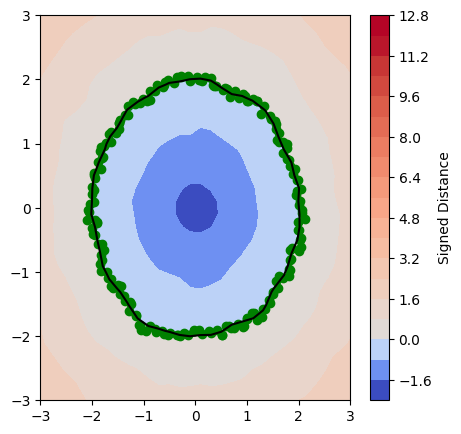

In [ ]:
#plot sdf_circle_wave
fig, ax = plt.subplots(figsize=(5, 5))
xx, yy, sdf_values = sdf.plot_sdf(ax, model)

#convert sdf to numpy
sdf_values = sdf_values.cpu().detach().numpy()

norm = matplotlib.colors.TwoSlopeNorm(vmin=np.min(sdf_values), vcenter=0, vmax=np.max(sdf_values))

# Plot the SDF with the centered colormap
contour = plt.contourf(xx, yy, sdf_values, levels=20, cmap="coolwarm", norm=norm)

# Add a colorbar with label
plt.colorbar(contour, label="Signed Distance")

#voronoi_plot_2d(voronoi_initial, ax=ax, show_vertices=False, line_colors='blue')
#plot points index
#for i, point in enumerate(points):
    #ax.text(point[0], point[1], str(i), color='black')
    #plot points coordinates
    #ax.text(point[0], point[1], f"({point[0]:.2f}, {point[1]:.2f})", color='pink')

#plot the delaunay simplices with index
#for i, simplex in enumerate(delaunay_triangulation.simplices):
    # Compute the circumcenter of the simplex
    #circumcenter = np.mean(points[simplex], axis=0)
    #ax.text(circumcenter[0], circumcenter[1], str(i), color='blue')

# plot the ridge points with index
#for i, (point1, point2) in enumerate(voronoi_initial.ridge_points):
    # Compute the midpoint of the ridge
    #midpoint = (points[point1] + points[point2]) / 2
    #ax.text(midpoint[0], midpoint[1], str(i), color='green')

# # Plot the points
# plt.scatter(points[:, 0], points[:, 1], color='blue')
# #change color of point 0
# plt.scatter(points[0, 0], points[0, 1], color='red')
# Plot the Delaunay triangulation
#ax.triplot(points[:, 0], points[:, 1], delaunay_triangulation.simplices, color='red')

#scatter vectorized_v
plt.scatter(vectorized_v[:, 0], vectorized_v[:, 1], color='green')
# scatter computed
#plt.scatter(computed_v[:, 0], computed_v[:, 1], color='yellow')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()